# １．時系列分析の基礎概念

## 1.1 時系列分析の基礎
### 用語：時系列データ

時間の推移と共に観測されるデータのこと。

時系列データの代表例であるホワイトノイズを R で生成してみる。

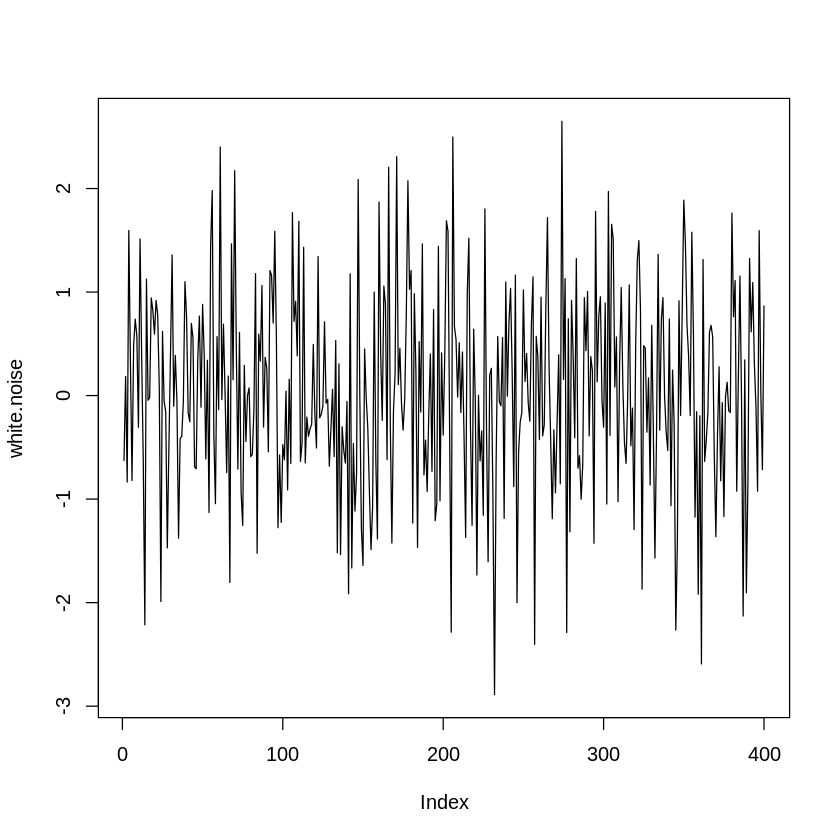

In [1]:
# 時系列データの代表例であるホワイトノイズを生成
set.seed(1)
white.noise <- rnorm(n=400)
plot(white.noise, type="l")

## 基本統計量と時系列モデル
### 用語：自己共分散
同一の時系列データにおける異時点間での共分散。
k 時点離れたデータ間の自己共分散 $\gamma_{k,t}$ は k 次の ***自己共分散*** と呼ばれ、以下の式で定義される。

$$\gamma_{k,t} = \mbox{Cov}(y, y_{t-k}) = \mbox{E}[(y_t - \mu_t)(y_{t-k} - \mu_{t-k})]$$

$\gamma_{k,t}$ が 0 であるなら、そのデータは k 時点前のデータと現在のデータの間に相関がないことを表している。

In [53]:
len = length(white.noise)

# 標本平均(ホワイトノイズなので標本平均を平均として扱う)
mu = mean(white.noise)

# 手動で計算(ホワイトノイズなので自己共分散は時刻tに依らない)
gamma0 = sum((white.noise[1 : len]       - mu) * (white.noise[1 : len] - mu)) / len
gamma1 = sum((white.noise[1 : (len - 1)] - mu) * (white.noise[2 : len] - mu)) / (len - 1)
gamma2 = sum((white.noise[1 : (len - 2)] - mu) * (white.noise[3 : len] - mu)) / (len - 2)

# 1次以降の自己共分散は0次と比較して小さい
sprintf("gamma0: %f", gamma0)
sprintf("gamma1: %f", gamma1)
sprintf("gamma2: %f", gamma2)

# 答え合わせ
acf(white.noise, type="covariance", plot=FALSE)
# gamma1, gamma2 は len-1 や len-2 で割るより len で割ったほうが acf の計算結果に近くなる？

[1] "gamma0: 0.937668"

[1] "gamma1: -0.043558"

[1] "gamma2: 0.014045"


Autocovariances of series ‘white.noise’, by lag

       0        1        2        3        4        5        6        7 
 0.93767 -0.04345  0.01398 -0.01581 -0.02041  0.00731 -0.04925  0.01809 
       8        9       10       11       12       13       14       15 
-0.08440  0.06384 -0.02009 -0.04081 -0.03991  0.06398  0.09378  0.06391 
      16       17       18       19       20       21       22       23 
 0.04086 -0.00642 -0.02903 -0.01876 -0.04146 -0.07039 -0.02346 -0.01732 
      24       25       26 
-0.02386  0.04956 -0.04327 

### 用語：自己相関係数
自己共分散は、値が単位に依存してしまう問題がある。つまり自己共分散の数値だけみても、それが大きいのか小さいのか判断できない。そこで自己共分散を標準化した k 次の ***自己相関係数*** $\rho_{k,t}$ を以下のように定義する。

$$\rho_{k,t} = \mbox{Corr}(y_t, y_{t-k}) = \frac{\mbox{Cov}(y_t, y_{t-k})}{\sqrt{\mbox{Var}(y_t) \cdot \mbox{Var}(y_{t-k})}} = \frac{\gamma_{k,t}}{\sqrt{\gamma_{0,t} \gamma_{0,t-k}}}$$

ここで $\gamma_{0,t}$ は、時点tと時点tの自己共分散で、つまり分散そのもの。よって $\mbox{Var}(y_t) = \gamma_{0,t}$ である。

[1] "rho0: 1.000000"

[1] "rho1: -0.046454"

[1] "rho2: 0.014979"


Autocorrelations of series ‘white.noise’, by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.046  0.015 -0.017 -0.022  0.008 -0.053  0.019 -0.090  0.068 -0.021 
    11     12     13     14     15     16     17     18     19     20     21 
-0.044 -0.043  0.068  0.100  0.068  0.044 -0.007 -0.031 -0.020 -0.044 -0.075 
    22     23     24     25     26 
-0.025 -0.018 -0.025  0.053 -0.046 

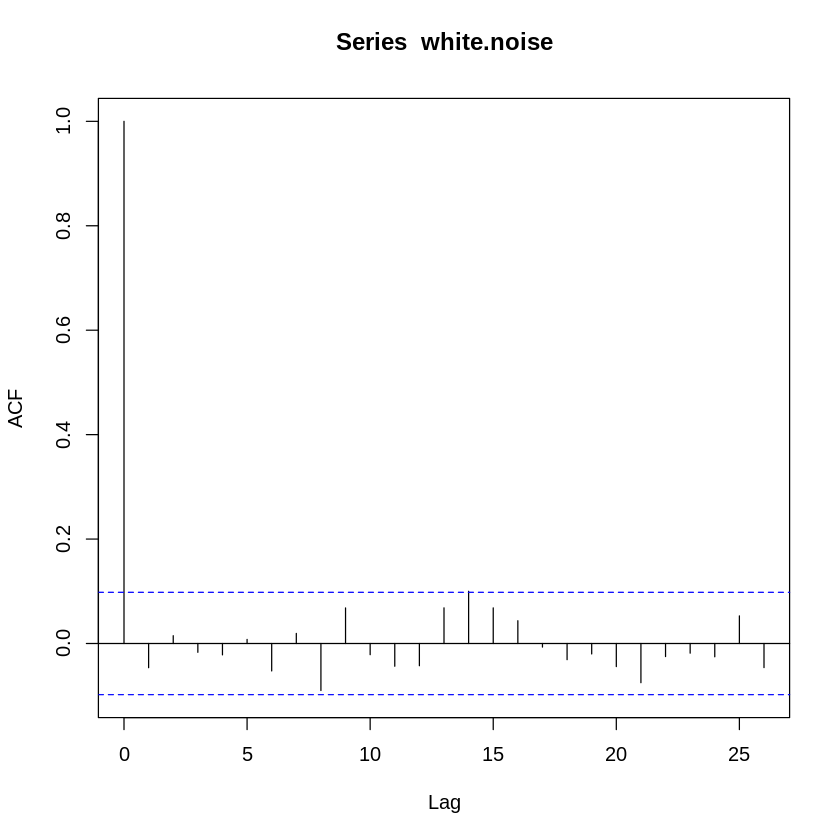

In [55]:
# ホワイトノイズなので自己共分散 gamma は時刻に依らない、なので自己相関係数 rho も時刻に依らない
rho0 = gamma0 / sqrt(gamma0 * gamma0)
rho1 = gamma1 / sqrt(gamma0 * gamma0)
rho2 = gamma2 / sqrt(gamma0 * gamma0)

# 1次以降の自己相関は0次と比較して小さい
sprintf("rho0: %f", rho0)
sprintf("rho1: %f", rho1)
sprintf("rho2: %f", rho2)

# 答え合わせ(ホワイトノイズなので1次以降の自己相関が小さいことが小さいことが確認できる)
acf(white.noise, type="correlation", plot=FALSE)
acf(white.noise, type="correlation", plot=TRUE)

## 1.2 定常性
### 用語：弱定常性
任意の t と k に対して
$$E(y_t) = \mu$$
$$\mbox{Cov}(y_t,y_{t-k}) = E[(y_t - \mu)(y_{t-k} - \mu)] = \gamma_k$$
が成立する場合、過程は ***弱定常*** といわれる。

これはつまり弱定常過程は

- 時点 t に依らず、過程の期待値が不変で $\mu$ という値を取る
- 過程の自己共分散は、ラグ k だけに依存し、時点 t には依存しない

という性質を持つということ。

#### 定常性の仮定が必要な理由
一般の統計データは、同じ母集団から適当な数のサンプルを取得できることが期待できるが、時系列データの場合は難しい。
たとえば 2017/12/27 を何度も繰り返し、その降水量を複数回サンプリングすることはできない。
このため得られたデータの期待値や分散を推定することができない。

そこで、時系列データを発生させているデータ生成過程に適当な構造を仮定して様々な推定を行えるようにしたい。
弱定常性は扱いやすい仮定で、よく使われる。

### 用語：強定常性
任意の t と k に対して、$(y_t, y_{t+1}, ..., y_{t+k})'$ の同時分布が同一となる場合、過程は ***強定常*** であると言われる。

## 1.3 ホワイトノイズ
### 用語：iid(independently and identically distributed) 系列
各時点のデータが互いに独立でかつ同一の分布に従う系の列は ***iid 系列*** と呼ばれる。

時系列データ $y_t$ が期待値 $\mu$ で分散 $\sigma^2$ の iid 系列であることを $y_t \sim \mbox{iid}(\mu, \sigma^2)$ と表記する。

たとえばデータ y が 20% の確率で値 40 を取り、80% の確率で値 -10 と取ると、y の各実現値は互いに独立で同一の分布に従うので iid 系列である。期待値は $\mu = \frac{0.2 * 40 + 0.8 * -10}{0.2 + 0.8} = 0$ で、分散は $\sigma^2 = \frac{(40 - 0)^2 * 0.2 + (-10 - 0)^2 * 0.8}{0.2 + 0.8} = \frac{1600 * 0.2 + 100 * 0.8}{0.2 + 0.8} = 400$ なので、$y_t \sim iid(0, 400)$ である。

### 用語：ホワイトノイズ
すべての時点 t において、
$$E(\epsilon_t) = 0$$
$k = 0$ のとき
$$\gamma_k = E(\epsilon_t\epsilon_{t-k}) = \sigma^2$$
$k \neq 0$ のとき
$$\gamma_k = E(\epsilon_t\epsilon_{t-k}) = 0$$
が成立するとき、$\epsilon_t$ は ***ホワイトノイズ*** と呼ばれる。

ホワイトノイズは、常に期待値が 0 で分散が一定($\sigma$)で自己相関がないようなデータである。iid 系列の仮定よりも少し弱い。ホワイトノイズは弱定常性を持つ。一般にホワイトノイズと正規分布は関係がない。正規過程を仮定したホワイトノイズは iid 系列になる。

## 自己相関の検定
対象とする時系列データが弱定常であるとすれば、過程の期待値や自己相関は時間に依存しないので、簡単に計算することができる。得られているデータを標本として計算した期待値、自己共分散、自己相関はそれぞれ標本平均、標本自己共分散、標本自己相関と呼ばれる。この標本自己相関 $\rho$ が 0 と等しいという帰無仮説を検定すればよい。特定の次数の自己相関を検定する方法と、すべての次数の自己相関をまとめて検定する方法がある(かばん検定)。